In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
%matplotlib widget

In [2]:
%matplotlib inline
from COB_model import get_COB_model
from COBresolve import COBresolve_image
import higra as hg
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [3]:
weigth_path='COB_PASCALContext_trainval.h5'
input_shape=(None,None,3)
model=get_COB_model(weigth_path,input_shape)
predicter=COBresolve_image(model)


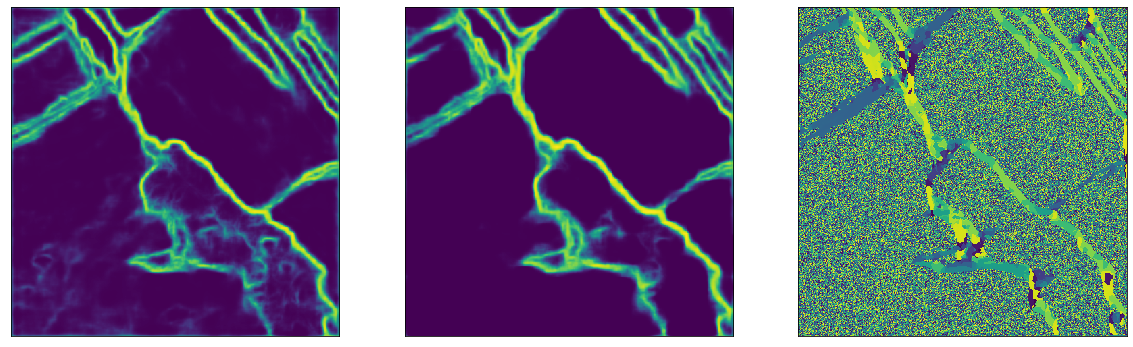

In [48]:
# image_name='10078660_15_cr.png'
# image_name='2010_005731.png'
image_name='2010_005731_.png'
# image_name='101087.jpg'
# image_name='2018.ppm'
base='../demo'
image_path = '{0}/{1}'.format(base,image_name)

image=np.asarray(Image.open(image_path))#.transpose(1,0,2)


output=predicter.resolve_imar(image)
# output=predicter.resolve_image(image_path)

plt.figure(figsize=(20,20))
for num, im in enumerate(output):
    plt.subplot(1,3,num+1)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

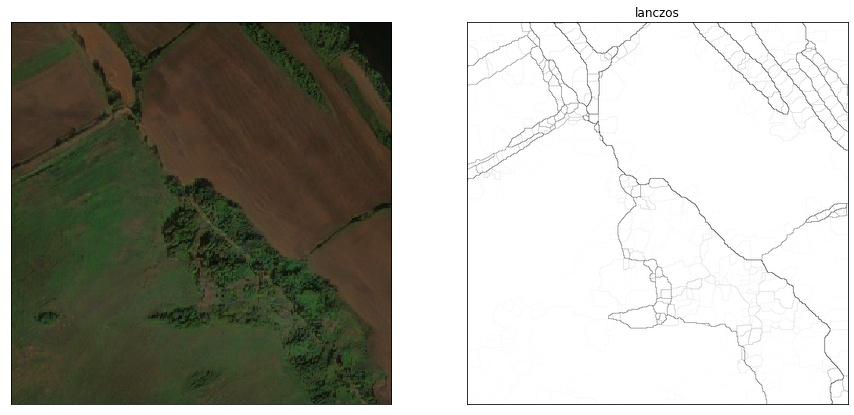

In [49]:
# get hierarchical contours

size = image.shape[:2]

gradient_coarse = output[1]
gradient_fine = output[0]
gradient_orientation = output[2]

graph = hg.get_4_adjacency_graph(size)
edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)

# special handling for angles to wrap around the trigonometric cycle...
edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
outlines=hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined))

intr=['none', 'nearest', 'bilinear', 'bicubic',
    'spline16', 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser',
    'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc',
    'lanczos']

plt.figure(figsize=(15,20))
# plt.figure(figsize=(10,10))

intrr=16
for num, im in enumerate([image, outlines]):
    plt.subplot(1,2,num+1)
    if len(im.shape)==2:
        plt.imshow(1-im,cmap='gray', interpolation=intr[intrr])
        plt.title(intr[intrr])
    else:
        plt.imshow(im)
    plt.xticks([])
    plt.yticks([])



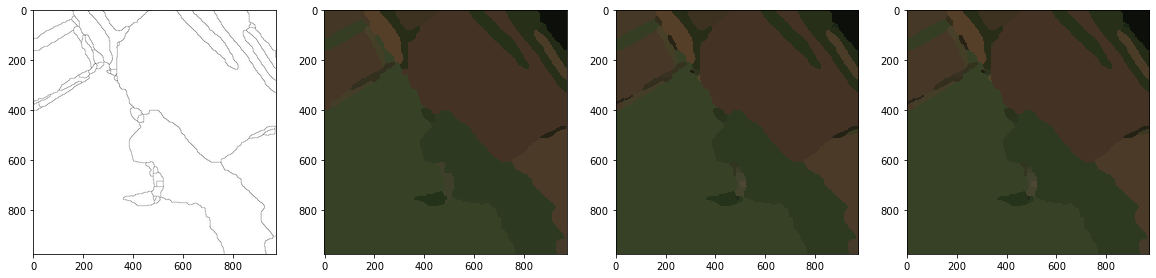

In [52]:
# dim=np.array(Image.fromarray(image).resize((641,961),Image.NEAREST))/255
dim=np.array(Image.fromarray(image).resize((973,977),Image.NEAREST))/255

outlines0=1/(1+np.exp(-outlines))
outlines0[outlines0<0.6]=0

gradient = outlines0

# Edge weighted 4-adjacency graph
graph        = hg.get_4_adjacency_graph(gradient.shape[:2])
edge_weights = hg.weight_graph(graph, gradient, hg.WeightFunction.mean)

# Watershed hierarchy by area and its saliency map
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm              = hg.saliency(tree, altitudes)

mean_color = hg.attribute_mean_vertex_weights(tree, dim)
cut_helper = hg.HorizontalCutExplorer(tree, altitudes)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(1-outlines0, cmap='gray', interpolation=intr[intrr])
for i, c in enumerate([25, 100, 200]):
    cut        = cut_helper.horizontal_cut_from_num_regions(c)
    simplified = cut.reconstruct_leaf_data(tree, mean_color)
    plt.subplot(1,4,i+2)
    plt.imshow(simplified)